# Run 6hr differential correlation

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import itertools
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig5/main/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [5]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [6]:
# adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [7]:
adata.shape

(69958, 36601)

In [8]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [10]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
# adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

### Setup memento

In [11]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [12]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [13]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

Version 0.0.6


### Define ISG classes

In [14]:
isg_classes = pd.read_csv('../isg_classes.csv')

In [15]:
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()

In [41]:
tf_df = pd.read_csv('../baseline/human_tf.txt', sep='\t')
tf_df = tf_df.query('Family != "Others"')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA', 'NLRC5']

### Compute DC genes for all TFs

In [43]:
moments = {}
cts = ['C', 'B', 'BC']
tps = ['3']
ct = ['C']
stims = ['beta']
for tp in tps:
    moments[tp] = {}
    for stim in stims:
        
        adata_stim = adata.copy()[

            adata.obs.ct.isin(ct) & \
            adata.obs.stim.isin([stim, 'control']) & \
            adata.obs.time.isin(['0', tp])].copy()
        
        time_converter={0:0, int(tp):1}
        adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])
        adata_stim.obs['group'] = 1

        memento.create_groups(adata_stim, label_columns=['donor', 'time_step'])
        memento.compute_1d_moments(adata_stim, min_perc_group=.9)

        available_genes = adata_stim.var.index.tolist()
        available_tfs = list(set(tf_list) & set(available_genes))
        available_isgs = list(set(available_genes) & set(t1_isg))
        print(len(available_tfs), len(available_isgs))
        memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, available_isgs)))

        
        moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
        moments[tp][stim] = moment_df.copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


581 201


### Read 1D HT result

In [68]:
result_1d = memento.get_1d_ht_result(sc.read(data_path + 'binary_test_latest/C_beta_3.h5ad'))
result_1d['de_fdr'] = memento.util._fdrcorrect(result_1d['de_pval'])
result_1d.index = result_1d['gene']

In [75]:
agg = moment_df.groupby('gene_1').agg({'time_step_1':'mean', 'time_step_0':'mean'})
agg['diff'] = agg['time_step_1'] - agg['time_step_0']
tf_df.index = tf_df.Symbol
agg = agg.join(result_1d).join(tf_df[['Family']])

In [76]:
agg.loc['STAT1']

time_step_1    0.391121
time_step_0    0.325038
diff           0.066083
gene              STAT1
de_coef        1.477862
de_se          0.044785
de_pval             0.0
dv_coef       -0.659008
dv_se          0.094982
dv_pval             0.0
de_fdr              0.0
Family             STAT
Name: STAT1, dtype: object

In [78]:
top_tfs = agg.sort_values('diff', ascending=False).head(20).index.tolist()

In [90]:
def get_2d_ht(ct, stim):
    
    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.time.isin(['48', '3'])& \
        adata.obs.stim.isin(['control', stim])].copy()
    time_converter={3:0, 48:1}
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

    memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    
    available_tfs = list(set(top_tfs) & set(adata_stim.var.index))
    available_genes = adata_stim.var.index.tolist()
    available_isgs = list(set(available_genes) & set(t1_isg))
    
    memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, available_isgs)))
    
    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + time_step',
        treatment_col='time_step', 
        num_boot=10000, 
        approx=False,
        resampling='permutation',
        verbose=1,
        num_cpus=92)
    
    
    adata_stim.write(data_path + 'dc_48hr/{}_{}_isgs.h5ad'.format(ct[0], stim))

In [91]:
alpha_ht_df = get_2d_ht(['ciliated'], 'alpha')

[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:   10.6s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:   20.1s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   37.1s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   59.7s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:  1.4min
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:  1.8min
[Parallel(n_jobs=92)]: Done 3760 out of 3760 | elapsed:  2.5min finished
... storing 'memento_group' as categorical


In [92]:
beta_ht_df = get_2d_ht(['ciliated'], 'beta')

[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    7.8s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:   19.0s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   35.3s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   51.5s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:  1.2min
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:  1.7min
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:  2.1min
[Parallel(n_jobs=92)]: Done 4465 out of 4465 | elapsed:  2.6min finished
... storing 'memento_group' as categorical


In [93]:
get_2d_ht(['ciliated'], 'gamma')

[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    5.8s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:   11.9s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   25.5s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   39.9s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   57.5s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:  1.3min
[Parallel(n_jobs=92)]: Done 3655 out of 3655 | elapsed:  1.7min finished
... storing 'memento_group' as categorical


### Perform DC for all TFs considered

In [24]:
def get_2d_ht_all(ct, stim):
    
    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.time.isin(['0', '6']) & \
        adata.obs.stim.isin(['control', stim])].copy()
    time_converter={0:0, int('6'):1}
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

    memento.create_groups(adata_stim, label_columns=['time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')
    
    available_tfs = list(set(filtered_tfs) & set(moment_1d_df[0].gene))
    
    memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, adata_stim.var.index)))
    
    moment_df = memento.get_2d_moments(adata_stim, groupby='time')
    
    candidates = moment_df.query('time_0 > 0.35 | time_6 > 0.35')
    candidates = list(zip(candidates['gene_1'], candidates['gene_2']))
    
    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.time.isin(['0', '6']) & \
        adata.obs.stim.isin(['control', stim])].copy()
    
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

    memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    memento.compute_2d_moments(adata_stim, candidates)
    
    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + time_step',
        cov_column='time_step', 
        num_boot=10000, 
        verbose=1,
        num_cpus=13)
    
    
    ht_df = memento.get_2d_ht_result(adata_stim)
    
    return ht_df

In [25]:
beta_df = get_2d_ht_all(['ciliated'], 'beta')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/main.py:594: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:   12.1s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   25.4s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   43.7s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  3.0min


In [26]:
beta_ht_df.to_csv(data_path + 'beta_dc_result_20210504.csv', index=False)

### Compute correlations between ISGs

In [17]:
igs = ['ISG15', 'IFIT1', 'IFIT2', 'IFIT3', 'MX1', 'MX2', 'OASL']

In [19]:
# tf = 'STAT1'
# ct = ['ciliated']
# stim = 'beta'

def get_2d_moments_isg(tf, ct, stim):
    
    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim])].copy()
    # time_converter={0:0, int(tp):1}
    # adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

    memento.create_groups(adata_stim, label_columns=['time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

    memento.compute_2d_moments(adata_stim, list(itertools.combinations(igs, 2)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='time')
    
    return moment_df

In [20]:
beta_isg_df = get_2d_moments_isg('STAT1', ['ciliated'], 'beta')

/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log


In [22]:
beta_isg_df[['gene_1', 'gene_2'] + ['time_' + str(i) for i in [0, 3, 6, 9, 24, 48]]]

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
0,ISG15,IFIT1,0.912525,0.859475,0.860717,0.894880,0.849657,0.824642
1,ISG15,IFIT2,0.709213,0.766188,0.748801,0.839606,0.855540,0.743067
2,ISG15,IFIT3,0.738290,0.768141,0.814666,0.828783,0.823922,0.729833
3,ISG15,MX1,0.819765,0.814883,0.833459,0.875096,0.857120,0.787441
4,ISG15,MX2,0.731378,0.700568,0.671598,0.814559,0.801095,0.747115
5,ISG15,OASL,0.702671,0.723763,0.680118,0.818876,0.741394,0.795438
6,IFIT1,IFIT2,0.627455,0.830298,0.807820,0.860115,0.852993,0.865924
7,IFIT1,IFIT3,0.802160,0.856047,0.889002,0.881489,0.884011,0.875954
8,IFIT1,MX1,0.970948,0.821224,0.825487,0.831096,0.733519,0.771687
9,IFIT1,MX2,0.690637,0.677439,0.632088,0.792340,0.712742,0.747235


### Compute correlations for STAT1

In [15]:
tf = 'STAT1'
ct = ['ciliated']
stim = 'beta'

def get_2d_moments(tf, ct, stim):
    
    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim])].copy()
    # time_converter={0:0, int(tp):1}
    # adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

    memento.create_groups(adata_stim, label_columns=['time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

    memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='time')
    
#     memento.ht_2d_moments( 
#         adata_stim, 
#         formula_like='1 + time_step',
#         cov_column='time_step', 
#         num_boot=10000, 
#         verbose=1,
#         num_cpus=13)
    
#     ht_df = memento.get_2d_ht_result(adata_stim)
    
    return moment_df

In [16]:
beta_df = get_2d_moments('STAT1', ['ciliated'], 'beta')
alpha_df = get_2d_moments('STAT1', ['ciliated'], 'alpha')
gamma_df = get_2d_moments('STAT1', ['ciliated'], 'gamma')
lambda_df = get_2d_moments('STAT1', ['ciliated'], 'lambda')

beta_df['stim'] = 'beta'
alpha_df['stim'] = 'alpha'
df = pd.concat([alpha_df, beta_df])

/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/main.py:578: RuntimeWarning: invalid value encountered in true_divide
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [19]:
beta_df['isgf3'] = beta_df.gene_2.apply(lambda x: 'in TSS' if x in isgf3_genes else 'rest')

### ISGF3 correlations for alpha/beta interferon

In [32]:
beta_df.head(5)

,gene_1,gene_2,time_9,time_3,time_0,time_6,time_48,time_24,stim,isgf3
0,STAT1,LINC01409,-0.175255,0.022280,0.389398,0.091183,-0.208910,-0.145140,beta,rest
1,STAT1,NOC2L,-0.070694,0.070377,0.127526,0.105913,-0.018320,-0.201853,beta,rest
2,STAT1,HES4,0.433971,0.389929,0.139460,0.436864,0.531960,0.601891,beta,rest
3,STAT1,ISG15,0.756565,0.751469,0.712075,0.702480,0.766635,0.835480,beta,in TSS
4,STAT1,AGRN,0.447522,0.238193,0.227282,0.222979,0.311116,0.186166,beta,rest


In [33]:
alpha_df.head(5)

,gene_1,gene_2,time_9,time_3,time_0,time_48,time_6,time_24,stim
0,STAT1,LINC01409,0.058433,0.172438,0.389398,0.078051,0.003680,0.365823,alpha
1,STAT1,NOC2L,-0.029808,0.189881,0.127526,0.249579,0.348690,-0.052135,alpha
2,STAT1,HES4,0.438277,0.379277,0.139460,0.363275,0.388632,0.525524,alpha
3,STAT1,ISG15,0.695766,0.733140,0.712075,0.699458,0.661231,0.768229,alpha
4,STAT1,AGRN,0.204388,0.225468,0.227282,0.297670,0.132081,0.174836,alpha


In [28]:
a =  beta_df[['gene_2', 'time_0']].rename(columns={'gene_2':'gene', 'time_0':'corr'})
b =  beta_df[['gene_2', 'time_6']].rename(columns={'gene_2':'gene', 'time_6':'corr'})

a['time'] = 'ctrl'
b['time'] = 'stim'
beta_long_df = pd.concat([a, b])

beta_long_df['isgf3'] = beta_long_df.gene.apply(lambda x: 'in TSS' if x in isgf3_genes else 'rest')

In [29]:
a =  alpha_df[['gene_2', 'time_0']].rename(columns={'gene_2':'gene', 'time_0':'corr'})
b =  alpha_df[['gene_2', 'time_6']].rename(columns={'gene_2':'gene', 'time_6':'corr'})

a['time'] = 'ctrl'
b['time'] = 'stim'
alpha_long_df = pd.concat([a, b])

alpha_long_df['isgf3'] = alpha_long_df.gene.apply(lambda x: 'in TSS' if x in isgf3_genes else 'rest')

In [22]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [42]:
pbmc_data_path = '/data_volume/parameter_estimation/'
pbmc_long_df = pd.read_csv(pbmc_data_path + 'stat1_corrs.csv').rename(columns={'stim':'time'})

In [43]:
pbmc_long_df.head(5)

,gene,corr,time,isgf3,high_exp
0,ISG15,0.057578,ctrl,ISGF3,True
1,AURKAIP1,0.128053,ctrl,rest,True
2,MRPL20,-0.059311,ctrl,rest,True
3,SSU72,-0.078957,ctrl,ISGF3,True
4,GNB1,-0.000787,ctrl,rest,True


In [45]:
ab_joined = alpha_long_df.merge(beta_long_df, on=['gene', 'time'], suffixes=('_alpha', '_beta'))
pbmc_joined = beta_long_df.merge(pbmc_long_df, on=['gene', 'time'], suffixes=('_beta', '_pbmc'))

In [74]:
pbmc_joined.head(5)

,gene,corr_beta,time,isgf3_beta,corr_pbmc,isgf3_pbmc,high_exp
0,ISG15,0.712075,ctrl,in TSS,0.057578,ISGF3,True
1,AURKAIP1,0.142373,ctrl,rest,0.128053,rest,True
2,MRPL20,0.047689,ctrl,rest,-0.059311,rest,True
3,SSU72,-0.026395,ctrl,rest,-0.078957,ISGF3,True
4,GNB1,0.095139,ctrl,rest,-0.000787,rest,True


In [70]:
stats.pearsonr(pbmc_joined.query('time == "stim"').corr_beta, pbmc_joined.query('time == "stim"').corr_pbmc)

(0.1712953648060725, 2.201513571182445e-10)

In [77]:
stats.pearsonr(ab_joined.query('time == "stim"').corr_beta, ab_joined.query('time == "stim"').corr_alpha)

(0.6929252536906498, 0.0)

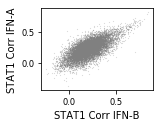

In [69]:
plt.figure(figsize=(2, 1.5))
plt.scatter(ab_joined.query('time == "stim"').corr_beta, ab_joined.query('time == "stim"').corr_alpha, s=0.01, color='grey')
plt.ylabel('STAT1 Corr IFN-A'); plt.xlabel('STAT1 Corr IFN-B')
plt.savefig(fig_path + 'stat1_corr_ab.png', bbox_inches='tight', dpi=300)


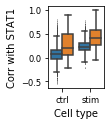

In [39]:
plt.figure(figsize=(1, 1.5))
sns.boxplot(x='time', y='corr', hue='isgf3', data=alpha_long_df, fliersize=0.1)

plt.xlabel('Cell type'); plt.ylabel('Corr with STAT1');
plt.legend([], frameon=False)
# plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.4), frameon=False)
# plt.ylim(-.8, 0.6)
plt.savefig(fig_path + 'isgf3_vs_rest_alpha.pdf', bbox_inches='tight')



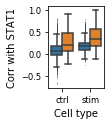

In [40]:
plt.figure(figsize=(1, 1.5))
sns.boxplot(x='time', y='corr', hue='isgf3', data=beta_long_df, fliersize=0.1)

plt.xlabel('Cell type'); plt.ylabel('Corr with STAT1');
plt.legend([], frameon=False)

# plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.15))
# plt.ylim(-.8, 0.6)
plt.savefig(fig_path + 'isgf3_vs_rest_beta.pdf', bbox_inches='tight')



In [21]:
beta_df.head(2)

,gene_1,gene_2,time_9,time_3,time_0,time_6,time_48,time_24,stim
0,STAT1,LINC01409,-0.175255,0.022280,0.389398,0.091183,-0.20891,-0.145140,beta
1,STAT1,NOC2L,-0.070694,0.070377,0.127526,0.105913,-0.01832,-0.201853,beta


In [ ]:
plt.figure(figsize=(2.5, 3))
sns.boxplot(x='ct', y='dv_coef', hue='isgf3', data=alpha_df.sort_values('isgf3'), palette='Set2')

plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.15))
# plt.ylim(-.8, 0.6)
# plt.savefig(fig_path + 'isgf3_vs_rest.pdf', bbox_inches='tight')



(-0.75, 1)

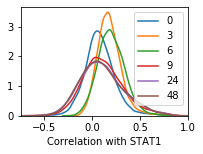

In [23]:
plt.figure(figsize=(3, 2))
for tp in ['0', '3', '6', '9', '24', '48']:#['0', '3', '6', '9', '24', '48']:
    sns.distplot(beta_df['time_' + tp], hist=False, label=tp)
# plt.legend(, frameon=False)
plt.xlabel('Correlation with STAT1')
plt.xlim(-0.75, 1)

In [81]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity

In [100]:
def ridgeplot(df):

    colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

    gs = grid_spec.GridSpec(6,1)
    fig = plt.figure(figsize=(3,2))

    i = 0

    ax_objs = []
    for i, tp in enumerate(['0', '3', '6', '9', '24', '48'][::-1]):
        x = df['time_' + tp].values
        x = x[np.isfinite(x)]
        x_d = np.linspace(-0.7,1, 1000)

        kde = KernelDensity(bandwidth=0.025, kernel='gaussian')
        kde.fit(x[:, None])

        logprob = kde.score_samples(x_d[:, None])

        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the distribution
        ax_objs[-1].plot(x_d, np.exp(logprob),lw=3, color=colors[i])
    #     ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color=colors[i])
    
        if i == 0:
            mode_corr = x_d[np.argmax(logprob)]
#             ax_objs[-1].plot([mode_corr, mode_corr], [0, 10])

        # setting uniform x and y lims
        ax_objs[-1].set_xlim(-0.4,0.7)
    #     ax_objs[-1].set_ylim(0,2.5)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])

        if i == 6-1:
            ax_objs[-1].set_xlabel("Correlation", fontsize=10,fontweight="bold")
        else:
            ax_objs[-1].set_xticklabels([])
            ax_objs[-1].set_xticks([])

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)
    #     
        ax_objs[-1].set_yticks([])
    #     adj_country = country.replace(" ","\n")
        ax_objs[-1].text(-0.5,0,tp,fontweight="bold",fontsize=14,ha="right")
        i += 1

    gs.update(hspace=-0.7)
    
#     plt.plot([mode_corr, mode_corr], [0, 10])

    # fig.text(0.07,0.85,"Distribution of Aptitude Test Results from 18 – 24 year-olds",fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return fig


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


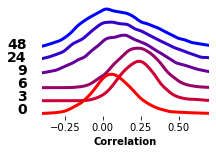

In [102]:
fig = ridgeplot(alpha_df)
fig.savefig(fig_path + 'corr_hist_alpha.pdf', bbox_inches='tight')

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


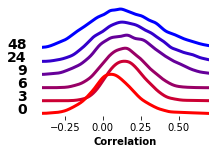

In [103]:
fig = ridgeplot(gamma_df)
fig.savefig(fig_path + 'corr_hist_gamma.pdf', bbox_inches='tight')

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


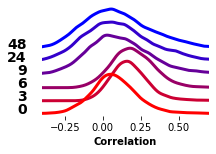

In [104]:
fig = ridgeplot(beta_df)
fig.savefig(fig_path + 'corr_hist_beta.pdf', bbox_inches='tight')

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


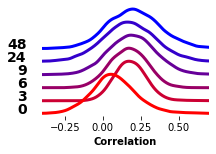

In [105]:
fig = ridgeplot(lambda_df)
fig.savefig(fig_path + 'corr_hist_lambda.pdf', bbox_inches='tight')

### TF ordering at timepoint 3

In [66]:
filtered_tfs = """MAFG
SPI1
ZNF655
MAX
ATF4
ATF3
IRF2
IRF1
ARID5A
BACH1
YY1
HMGA1
IRF7
STAT1
NR1H2
XBP1
ETV6
MSC
ATF5
MAFB
FOS
CEBPB
BBX
STAT3
REL
JUN
CEBPD
DDIT3
NR3C1
TGIF1
ZNF267
NFE2L2
HIF1A
AHR
GTF2B
CREM
HBP1
RELB
TFEC
YBX1
ELF1
JUNB
NFKB1
IRF9
RBPJ
KLF6""".split()

In [20]:
whitelist = beta_df.gene_2.tolist()

In [ ]:
tf_df_list = []
for tf in filtered_tfs:
    
    if tf not in whitelist:
        continue
    
    df = get_2d_moments(tf, ['ciliated'], 'beta')
    diff = (df['time_3'] - df['time_0']).mean()
    tf_df_list.append((tf, diff))
    del df
    
    print(tf)
#     break

tf_df_beta = pd.DataFrame(tf_df_list, columns=['tf', 'diff']).sort_values('diff', ascending=False)
tf_df_beta['tf'] = tf_df_beta['tf'].astype('category')
tf_order = tf_df_beta.sort_values('diff', ascending=False).tf.tolist()
tf_df_beta['tf'].cat.set_categories(tf_order, inplace=True)

In [97]:
tf_df_list = []
for tf in filtered_tfs:
    
    if tf not in whitelist:
        continue
    
    df = get_2d_moments(tf, ['ciliated'], 'alpha')
    diff = (df['time_3'] - df['time_0']).mean()
    tf_df_list.append((tf, diff))
    del df
    
    print(tf)
#     break

tf_df_alpha = pd.DataFrame(tf_df_list, columns=['tf', 'diff']).sort_values('diff', ascending=False)
tf_df_alpha['tf'] = tf_df_alpha['tf'].astype('category')
tf_order = tf_df_alpha.sort_values('diff', ascending=False).tf.tolist()
tf_df_alpha['tf'].cat.set_categories(tf_order, inplace=True)

/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/main.py:578: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


MAFG
ZNF655
MAX
ATF4
ATF3
IRF2
IRF1
BACH1
YY1
HMGA1
IRF7
STAT1
NR1H2
XBP1
ETV6
ATF5
FOS
CEBPB
BBX
STAT3
REL
JUN
CEBPD
DDIT3
NR3C1
TGIF1
ZNF267
NFE2L2
HIF1A
AHR
GTF2B
CREM
HBP1
RELB
YBX1
ELF1
JUNB
NFKB1
IRF9
RBPJ
KLF6


In [98]:
tf_df_list = []
for tf in filtered_tfs:
    
    if tf not in whitelist:
        continue
    
    df = get_2d_moments(tf, ['ciliated'], 'gamma')
    diff = (df['time_3'] - df['time_0']).mean()
    tf_df_list.append((tf, diff))
    del df
    
    print(tf)
#     break

tf_df_gamma = pd.DataFrame(tf_df_list, columns=['tf', 'diff']).sort_values('diff', ascending=False)
tf_df_gamma['tf'] = tf_df_gamma['tf'].astype('category')
tf_order = tf_df_gamma.sort_values('diff', ascending=False).tf.tolist()
tf_df_gamma['tf'].cat.set_categories(tf_order, inplace=True)

MAFG
ZNF655
MAX
ATF4
ATF3
IRF2
IRF1
BACH1
YY1
HMGA1
IRF7
STAT1
NR1H2
XBP1
ETV6
ATF5
FOS
CEBPB
BBX
STAT3
REL
JUN
CEBPD
DDIT3
NR3C1
TGIF1
ZNF267
NFE2L2
HIF1A
AHR
GTF2B
CREM
HBP1
RELB
YBX1
ELF1
JUNB
NFKB1
IRF9
RBPJ
KLF6


In [28]:
pbmc_data_path = '/data_volume/parameter_estimation/'
pbmc_tf_df = pd.read_csv(pbmc_data_path + 'tf_corr_changes.csv')

In [32]:
pbmc_tf_df = pbmc_tf_df.groupby('tf').diff.mean().reset_index()

In [33]:
joined = tf_df_beta.merge(tf_df_alpha, on='tf', suffixes=('_beta', '_alpha'))
joined_pbmc = tf_df_beta.merge(pbmc_tf_df, on='tf', suffixes=('_beta', '_pbmc'))
joined_pbmc = tf_df_beta.merge(pbmc_tf_df, on='tf', suffixes=('_beta', '_pbmc'))

In [29]:
joined.head(5)

,tf,diff_beta,diff_alpha
0,STAT1,0.099344,0.156776
1,IRF9,0.099322,0.125458
2,IRF7,0.086175,0.127605
3,TGIF1,0.071129,0.091961
4,BACH1,0.063072,0.085814


In [101]:
stats.pearsonr(joined['diff_beta'], joined['diff_alpha'])

(0.8844643874489025, 1.750514636467869e-14)

In [100]:
stats.pearsonr(joined_pbmc['diff_beta'], joined_pbmc['diff_pbmc'])

(0.294557632916126, 0.07262447260476375)

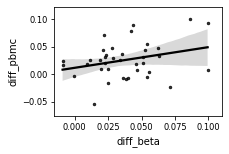

In [99]:
plt.figure(figsize=(3,2))
sns.regplot(joined_pbmc['diff_beta'], joined_pbmc['diff_pbmc'], scatter_kws={'s':6, 'color':'k'}, line_kws={'color':'k'})
plt.xlim(-0.015, 0.11); 
# plt.xlabel('Corr shift IFN-B'); plt.ylabel('Corr shift IFN-A')
# plt.savefig(fig_path + 'corr_shift_AB.pdf', bbox_inches='tight')


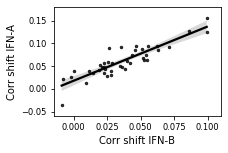

In [59]:
plt.figure(figsize=(3,2))
sns.regplot(joined['diff_beta'], joined['diff_alpha'], scatter_kws={'s':6, 'color':'k'}, line_kws={'color':'k'})
plt.xlim(-0.015, 0.11); 
plt.xlabel('Corr shift IFN-B'); plt.ylabel('Corr shift IFN-A')
plt.savefig(fig_path + 'corr_shift_AB.pdf', bbox_inches='tight')


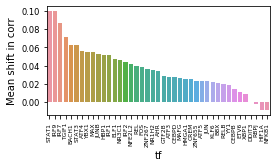

In [31]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'6',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

plt.figure(figsize=(4, 2))

sns.barplot(x='tf', y='diff', data=tf_df, errwidth=2)
plt.xticks(rotation=90);
plt.ylabel('Mean shift in corr')

plt.savefig(fig_path + 'tf_effect_sizes.pdf', bbox_inches='tight')


### Look for STAT1 DC genes

In [12]:
cts = [['ciliated'], ['bc', 'basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [13]:
import os

In [14]:
done_files = os.listdir('/data_volume/ifn_hbec/tf_test/')

In [14]:
tf = 'STAT1'

cts = [['ciliated']]
tps = ['3']
stims = ['beta']


for ct in cts:
    for tp in tps:
        for stim in stims:
            
            fname = '{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
            if fname in done_files:
                continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/coex_test/moments_{}_{}_{}_{}.csv'.format('-'.join(ct), stim, tp, tf), index=False)
            gene_list = adata_stim.var.index.tolist()#moment_df[(moment_df['time_step_0'] > 0.35) | (moment_df['time_step_1'] > 0.35)].gene_2.tolist()

            memento.compute_2d_moments(adata_stim, list(itertools.product([tf], gene_list)))

            memento.ht_2d_moments( 
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            if 'mv_regressor' in adata_stim.uns['memento']:
                del adata_stim.uns['memento']['mv_regressor']
            adata_stim.write('/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf))

### What are the STAT1 DC genes?

In [57]:
stim = 'beta'
tp = '3'
ct = ['ciliated']

fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
adata_result = sc.read(fname)

In [105]:

fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
adata_result = sc.read(fname)

moments = memento.get_2d_moments(adata_result, groupby='time')
res_df = memento.get_2d_ht_result(adata_result)
# rel_res_df = memento.get_2d_ht_result(adata_stim)

In [106]:
moments.query('gene_2.str.startswith("HLA-")', engine='python')

,gene_1,gene_2,time_3,time_0
324,STAT1,HLA-F,0.516336,0.303196
325,STAT1,HLA-A,0.435438,0.184255
326,STAT1,HLA-E,0.626379,0.415575
327,STAT1,HLA-C,0.530611,0.319793
328,STAT1,HLA-B,0.437998,0.201227


In [80]:
wired_pairs = moments.query('time_0 > 0.25 | time_{} > 0.25'.format(tp))

In [81]:
filtered_res_df = df.merge(wired_pairs, on=['gene_1', 'gene_2'])
filtered_res_df['corr_fdr'] = memento.util._fdrcorrect(filtered_res_df['corr_pval'])

In [ ]:
for g in filtered_res_df.query('corr_fdr < 0.1 & corr_coef > 0').gene_2.tolist():
    print(g)

In [52]:
filtered_res_df.shape

(869, 7)

In [53]:
res_df.shape

(891, 5)

### Re-run the STAT1 anaylsis for subset

In [15]:
tf = 'STAT1'

cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']


for ct in cts:
    for tp in tps:
        for stim in stims:
            
#             fname = '{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
#             if fname in done_files:
#                 continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            
            gene_list = adata_stim.var.index.tolist()
            
            memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_{}.csv'.format('-'.join(ct), stim, tp, tf), index=False)
#             gene_list = adata_stim.var.index.tolist()#moment_df[(moment_df['time_step_0'] > 0.35) | (moment_df['time_step_1'] > 0.35)].gene_2.tolist()

#             memento.compute_2d_moments(adata_stim, list(itertools.product([tf], gene_list)))

#             memento.ht_2d_moments( 
#                 adata_stim, 
#                 formula_like='1 + time_step',
#                 cov_column='time_step', 
#                 num_boot=10000, 
#                 verbose=1,
#                 num_cpus=13)

#             if 'mv_regressor' in adata_stim.uns['memento']:
#                 del adata_stim.uns['memento']['mv_regressor']
#             adata_stim.write('/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf))

starting ['ciliated'] 3 alpha
starting ['ciliated'] 3 beta
starting ['ciliated'] 3 gamma


/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/main.py:578: RuntimeWarning: invalid value encountered in true_divide


starting ['ciliated'] 3 lambda
starting ['ciliated'] 6 alpha
starting ['ciliated'] 6 beta
starting ['ciliated'] 6 gamma
starting ['ciliated'] 6 lambda
starting ['ciliated'] 9 alpha
starting ['ciliated'] 9 beta
starting ['ciliated'] 9 gamma
starting ['ciliated'] 9 lambda
starting ['ciliated'] 24 alpha
starting ['ciliated'] 24 beta
starting ['ciliated'] 24 gamma
starting ['ciliated'] 24 lambda
starting ['ciliated'] 48 alpha
starting ['ciliated'] 48 beta
starting ['ciliated'] 48 gamma
starting ['ciliated'] 48 lambda


### Compile STAT1 DC and correlation status

In [140]:
stim = 'gamma'
ct = ['ciliated']
tf = 'STAT1'

In [141]:

for tp in ['3', '6', '9', '24', '48']:
    
    print(tp)

    fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
    adata_result = sc.read(fname)
    
#     moments = memento.get_2d_moments(adata_result, groupby='time_step').rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    moments = pd.read_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_{}.csv'.format('-'.join(ct), stim, tp, tf)).rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    res_df = memento.get_2d_ht_result(adata_result)\
        .rename(columns={
            'corr_coef':'corr_coef' + '_' + tp,
            'corr_pval':'corr_pval' + '_' + tp})
    
    if tp == '3':

        pv_df = res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy()
        coef_df = res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy()
        moment_df = moments[['gene_1', 'gene_2', 'time_0', 'time_3']].copy()
        
    else:
        
        pv_df = pv_df.merge(res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        coef_df = coef_df.merge(res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        moment_df = moment_df.merge(moments[['gene_1', 'gene_2', 'time_{}'.format(tp)]].copy(), on=['gene_1', 'gene_2'], how='outer')
    
    
    

3
6
9
24
48


In [142]:
moment_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
3094,STAT1,HLA-A,0.172667,0.264742,0.196805,0.136728,0.101051,0.097405
3115,STAT1,HLA-C,0.314121,0.397101,0.337141,0.287205,0.147436,0.177297
3116,STAT1,HLA-B,0.196586,0.293571,0.286509,0.216158,0.123979,0.082816
6658,STAT1,B2M,0.177316,0.238690,0.196549,0.146857,0.054398,0.054794


### Check 2D moments over time

In [153]:
isg_genes = ['GBP1']

In [154]:
moment_df.query('gene_2.isin(@isg_genes)', engine='python')

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
450,STAT1,GBP1,0.552696,0.600947,0.589076,0.650046,0.637277,0.630829


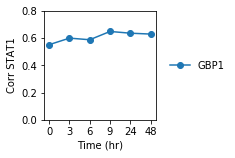

In [157]:
tf = 'STAT1'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_2.isin(@isg_genes)', engine='python').values[:, 2:].T, '-o')
plt.ylim(0, 0.8)
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.legend(moment_df.query('gene_2.isin(@isg_genes)', engine='python').gene_2.tolist(), loc='center right', frameon=False, bbox_to_anchor=(1.7, 0.5))

In [139]:
moment_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
3097,STAT1,HLA-A,0.184255,0.275632,0.204322,0.135832,0.103195,0.100389
3118,STAT1,HLA-C,0.319793,0.405229,0.340785,0.283306,0.145822,0.176469
3119,STAT1,HLA-B,0.201227,0.302763,0.290189,0.211899,0.122095,0.082566
6662,STAT1,B2M,0.184621,0.249761,0.203064,0.147616,0.055379,0.055576


In [117]:
coef_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene_1,gene_2,corr_coef_3,corr_coef_6,corr_coef_9,corr_coef_24,corr_coef_48
325,STAT1,HLA-A,0.404269,0.387095,NaN,NaN,NaN
327,STAT1,HLA-C,0.273931,0.351479,0.211282,0.15942,NaN
328,STAT1,HLA-B,0.381630,0.406874,NaN,NaN,NaN
649,STAT1,B2M,0.291344,0.413924,NaN,NaN,NaN


In [140]:
pv_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene_1,gene_2,corr_pval_3,corr_pval_6,corr_pval_9,corr_pval_24,corr_pval_48
216,STAT1,HLA-C,0.072993,NaN,NaN,NaN,NaN


In [69]:
vals = moment_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python').values[:, 2:]
# vals = moment_df.query('gene_2.isin(@isg_genes)', engine='python').values[:, 2:]

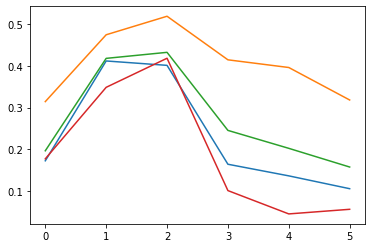

In [70]:
plt.plot(vals.T)

### Check some expresssion level over time

In [11]:
stim = 'beta'
ct = ['ciliated',]

In [12]:
subset = adata[adata.obs['cell_type'].isin(ct) & adata.obs.stim.isin(['control', stim])].copy().copy()
memento.create_groups(subset, label_columns=['time', 'donor'])
memento.compute_1d_moments(subset, min_perc_group=.9)
mean_df = memento.get_1d_moments(subset, groupby='time')[0][['gene'] + ['time_' + str(i) for i in [0, 3, 6, 9, 24, 48]]]
var_df = memento.get_1d_moments(subset, groupby='time')[1][['gene'] + ['time_' + str(i) for i in [0, 3, 6, 9, 24, 48]]]

/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log


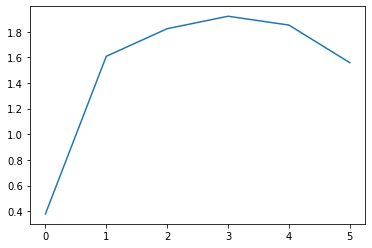

In [13]:
plt.plot(mean_df.query('gene.isin(["STAT1"])', engine='python').values[0, 1:])

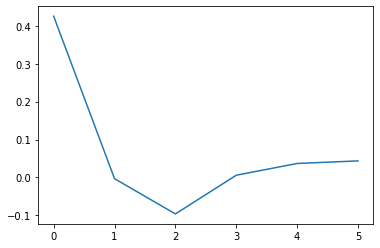

In [14]:
plt.plot(var_df.query('gene.isin(["STAT1"])', engine='python').values[0, 1:])

In [15]:
isg_genes = ['ISG15', 'MX1', 'MX2', 'ISG15', 'OAS1', 'OAS2', 'OAS3', 'OASL',]

In [16]:
isg_mat = mean_df.query('gene.isin(@isg_genes)', engine='python').values[:, 1:]

c1_mat = mean_df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python').values[:, 1:]
# c1_mat = c1_mat/c1_mat[:, 0].reshape(-1,1)

In [17]:
mean_df.query('gene.isin(["CREB3", "STAT1", "KLF6", "JUN"])', engine='python').values[1:].T

array([['STAT1', 'CREB3', 'KLF6'],
       [0.378761887550354, -0.5750117301940918, 1.1166375875473022],
       [1.607923150062561, -0.56675124168396, 1.3483425378799438],
       [1.8231121301651, -0.6197191476821899, 1.5926910638809204],
       [1.9202326536178589, -0.5898769497871399, 1.3491123914718628],
       [1.8513927459716797, -0.6063563823699951, 1.369952917098999],
       [1.5582482814788818, -0.5866938829421997, 1.5489485263824463]],
      dtype=object)

In [18]:
len(list(set(tfs) & set(subset.var.index)))

417

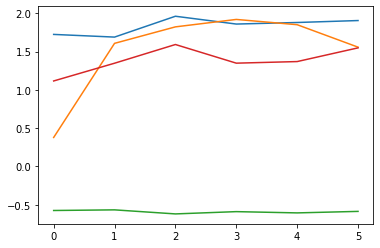

In [19]:
plt.plot(mean_df.query('gene.isin(["CREB3", "STAT1", "KLF6", "JUN"])', engine='python').values[:, 1:].T)

In [20]:
mean_df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
3221,HLA-A,1.656812,2.370405,2.487690,2.090583,2.035615,1.793220
3246,HLA-C,1.829254,2.479059,2.770877,2.521157,2.434578,2.142253
3247,HLA-B,1.967847,2.673597,2.807899,2.552474,2.472788,2.166302
6974,B2M,4.189476,4.438093,4.546697,4.348129,4.342992,4.125379


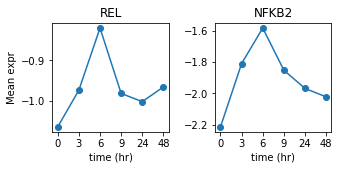

In [24]:
d = mean_df.query('gene.isin(["REL", "NFKB2"])', engine='python')
plt.figure(figsize=(5,2))
plt.subplots_adjust(wspace=0.4)
locs = [1, 2]
cs = [0, 2]
num=0
for idx, row in d.iterrows():
    plt.subplot(1,2,locs[num])
    plt.plot(row.values[1:], '-o')
    plt.title(row['gene'])
    plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
    if num == 0:
        plt.ylabel('Mean expr')
    plt.xlabel('time (hr)')
    num +=1

plt.savefig(fig_path + 'mhc_aux_mean.pdf', bbox_inches='tight')


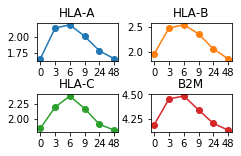

In [113]:
d = mean_df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')
plt.figure(figsize=(3.5,2))
plt.subplots_adjust(wspace=0.4, hspace=0.9)
locs = [1, 3, 2, 4]
cs = [0, 2, 1, 3]
num=0
for idx, row in d.iterrows():
    plt.subplot(2,2,locs[num])
    plt.plot(row.values[1:], '-o', color='C'+str(cs[num]))
    plt.title(row['gene'])
    plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
    num +=1
plt.savefig(fig_path + 'mhc_mean_expr.pdf', bbox_inches='tight')


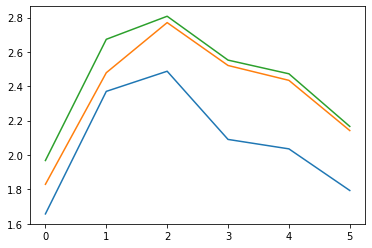

In [173]:
plt.plot(mean_df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python').values[:, 1:].T)

In [45]:
stim = 'beta'
ct = ['bc', 'basal', 'ciliated']

In [46]:
beta_stim = adata[adata.obs['cell_type'].isin(ct) & adata.obs.stim.isin(['control', stim])].copy().copy()

In [47]:
'LAIR1' in adata.var.index

True

([array([2333.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    8.]),
  array([3245.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    7.])],
 array([0.        , 0.06666667, 0.13333334, 0.2       , 0.26666668,
        0.33333334, 0.4       , 0.46666667, 0.53333336, 0.6       ,
        0.6666667 , 0.73333335, 0.8       , 0.8666667 , 0.93333334,
        1.        ], dtype=float32),
 <a list of 2 Lists of Patches objects>)

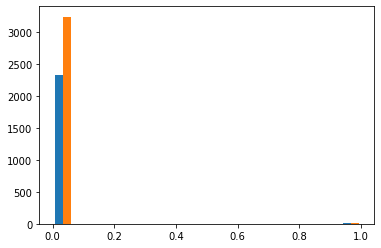

In [48]:
plt.hist([
    beta_stim[beta_stim.obs.time == '0', :][:, 'LAIR1'].X.todense().A1, 
    beta_stim[beta_stim.obs.time == '3', :][:, 'LAIR1'].X.todense().A1],
    bins=15)
# plt.hist(adata[adata.obs.time == '3', :][:, 'NLRC5'].X.todense().A1, bins=15)

In [62]:
df.query('gene.isin(["NLRC5"])', engine='python')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
7798,NLRC5,-2.844202,-1.290465,-0.997472,-0.961713,-0.956975,-0.941885


In [63]:
df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
3342,HLA-A,1.656812,2.370405,2.487690,2.090583,2.035615,1.793220
3367,HLA-C,1.829254,2.479059,2.770877,2.521157,2.434578,2.142253
3368,HLA-B,1.967847,2.673597,2.807899,2.552474,2.472788,2.166302
7264,B2M,4.189476,4.438093,4.546697,4.348129,4.342992,4.125379


### Correlation of MHC I transcripts to canonical TFs

In [ ]:

cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']


for ct in cts:
    for tp in tps:
        for stim in stims:
            
#             fname = '{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
#             if fname in done_files:
#                 continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            
            tf_list = list(set(tfs) & set(adata_stim.var.index))
            
            gene_list = adata_stim.var.index.tolist()
            
            memento.compute_2d_moments(adata_stim, list(itertools.product(tf_list, ["HLA-A", "HLA-B", "HLA-C", "B2M"])))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_mhc1.csv'.format('-'.join(ct), stim, tp), index=False)


            memento.ht_2d_moments( 
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            if 'mv_regressor' in adata_stim.uns['memento']:
                del adata_stim.uns['memento']['mv_regressor']
            adata_stim.write('/data_volume/ifn_hbec/tf_test/{}_{}_{}_mhc1.h5ad'.format('-'.join(ct), stim, tp))

In [75]:
stim = 'beta'
ct = ['ciliated']
for tp in ['3', '6', '9', '24', '48']:
    
    print(tp)

    
#     moments = memento.get_2d_moments(adata_result, groupby='time_step').rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    moments = pd.read_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_mhc1.csv'.format('-'.join(ct), stim, tp)).rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    res_df = memento.get_2d_ht_result(adata_result)\
        .rename(columns={
            'corr_coef':'corr_coef' + '_' + tp,
            'corr_pval':'corr_pval' + '_' + tp})
    
    if tp == '3':

        pv_df = res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy()
        coef_df = res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy()
        moment_df = moments[['gene_1', 'gene_2', 'time_0', 'time_3']].copy()
        
    else:
        
        pv_df = pv_df.merge(res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        coef_df = coef_df.merge(res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        moment_df = moment_df.merge(moments[['gene_1', 'gene_2', 'time_{}'.format(tp)]].copy(), on=['gene_1', 'gene_2'], how='outer')
    
    
    

3
6
9
24
48


### Hunt for some relevant TFs

In [25]:
stim = 'beta'
tp = '48'
ct = ['ciliated']

fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_mhc1.h5ad'.format('-'.join(ct), stim, tp)
adata_result = sc.read(fname)

In [26]:

fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_mhc1.h5ad'.format('-'.join(ct), stim, tp)
adata_result = sc.read(fname)

moments = pd.read_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_mhc1.csv'.format('-'.join(ct), stim, tp)).rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
res_df = memento.get_2d_ht_result(adata_result)
# rel_res_df = memento.get_2d_ht_result(adata_stim)

In [27]:
wired_pairs = moments.query('time_0 > 0.4 | time_{} > 0.4'.format(tp))

In [28]:
filtered_res_df = res_df.merge(wired_pairs, on=['gene_1', 'gene_2'])
filtered_res_df['corr_fdr'] = memento.util._fdrcorrect(filtered_res_df['corr_pval'])

In [29]:
pd.set_option('display.max_rows', 500)


In [30]:
filtered_res_df.query('corr_fdr < 0.1 & corr_coef > 0')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,time_0,time_48,corr_fdr
32,BARX2,B2M,0.468011,0.191003,0.032297,0.196546,0.406067,0.094991


In [31]:
filtered_res_df.query('corr_fdr < 0.05 & corr_coef > 0')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,time_0,time_48,corr_fdr


In [32]:
res_df

,gene_1,gene_2,corr_coef,corr_se,corr_pval
0,FOXA1,HLA-A,-0.056048,0.138552,0.672333
1,FOXA1,HLA-B,-0.017892,0.120553,0.886911
2,FOXA1,HLA-C,-0.039600,0.137438,0.766823
3,FOXA1,B2M,-0.067997,0.115958,0.542846
4,ELF3,HLA-A,-0.036777,0.079008,0.646335
...,...,...,...,...,...
1595,KLF2,B2M,0.047859,0.080182,0.540046
1596,ZBTB11,HLA-A,0.548664,0.214973,0.015998
1597,ZBTB11,HLA-B,0.549160,0.218291,0.024098
1598,ZBTB11,HLA-C,0.008946,0.237385,0.965903


In [33]:
moments.query('gene_2.str.startswith("HLA-")', engine='python')

,gene_1,gene_2,time_0,time_48
0,FOXA1,HLA-A,-0.010951,-0.036042
1,FOXA1,HLA-B,-0.105736,-0.113746
2,FOXA1,HLA-C,-0.110515,-0.128243
4,ELF3,HLA-A,0.221549,0.205085
5,ELF3,HLA-B,0.234490,0.230563
...,...,...,...,...
1593,KLF2,HLA-B,-0.076569,-0.043462
1594,KLF2,HLA-C,0.059468,0.079675
1596,ZBTB11,HLA-A,-0.097915,0.147713
1597,ZBTB11,HLA-B,-0.075090,0.170759


### Check correlations to other TFs over time

In [34]:
stim = 'beta'
ct = ['ciliated']
tf = 'STAT1'

In [35]:

for tp in ['3', '6', '9', '24', '48']:
    
    print(tp)

    fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_mhc1.h5ad'.format('-'.join(ct), stim, tp)
    adata_result = sc.read(fname)
    
#     moments = memento.get_2d_moments(adata_result, groupby='time_step').rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    moments = pd.read_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_mhc1.csv'.format('-'.join(ct), stim, tp)).rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    res_df = memento.get_2d_ht_result(adata_result)\
        .rename(columns={
            'corr_coef':'corr_coef' + '_' + tp,
            'corr_pval':'corr_pval' + '_' + tp})
    
    if tp == '3':

        pv_df = res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy()
        coef_df = res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy()
        moment_df = moments[['gene_1', 'gene_2', 'time_0', 'time_3']].copy()
        
    else:
        
        pv_df = pv_df.merge(res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        coef_df = coef_df.merge(res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        moment_df = moment_df.merge(moments[['gene_1', 'gene_2', 'time_{}'.format(tp)]].copy(), on=['gene_1', 'gene_2'], how='outer')
    
    
    

3
6
9
24
48


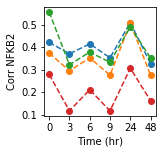

In [40]:
tf = 'NFKB2'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '--o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.savefig(fig_path + 'mhc_corr_NFKB2.pdf', bbox_inches='tight')


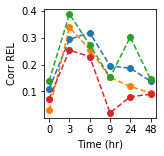

In [41]:
tf = 'REL'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '--o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.savefig(fig_path + 'mhc_corr_REL.pdf', bbox_inches='tight')


Text(0, 0.5, 'Corr RFX5')

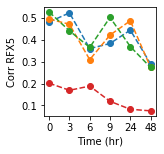

In [38]:
tf = 'RFX5'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '--o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))

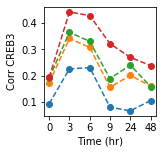

In [121]:
tf = 'CREB3'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '--o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.savefig(fig_path + 'mhc_creb3_corr.pdf', bbox_inches='tight')

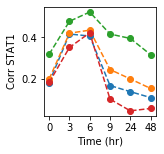

In [122]:
tf = 'STAT1'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '--o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.savefig(fig_path + 'mhc_stat1_corr.pdf', bbox_inches='tight')

In [242]:
tf = 'CREB3'

In [243]:
moment_df.query('gene_1 == "{}"'.format(tf))

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
828,CREB3,HLA-A,0.092283,0.225511,0.230557,0.079328,0.065209,0.104553
829,CREB3,HLA-B,0.172263,0.341903,0.307946,0.155191,0.201031,0.159479
830,CREB3,HLA-C,0.190355,0.365602,0.330579,0.188595,0.240382,0.157265
831,CREB3,B2M,0.193022,0.443010,0.429344,0.321969,0.269825,0.238096


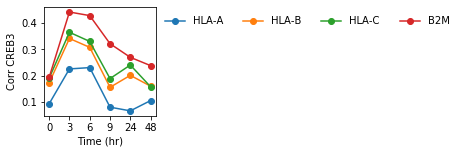

In [244]:
tf = 'CREB3'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '-o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.legend(['HLA-A', 'HLA-B', 'HLA-C', 'B2M'], ncol=4, frameon=False, bbox_to_anchor=(1,1))

Text(0, 0.5, 'Corr STAT6')

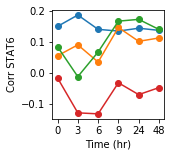

In [245]:
tf = 'STAT6'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '-o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))

Text(0, 0.5, 'Corr JUND')

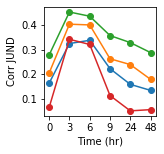

In [246]:
tf = 'JUND'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '-o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))

Text(0, 0.5, 'Corr ETS2')

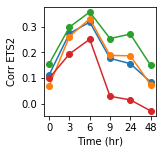

In [249]:
tf = 'ETS2'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '-o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))

### ISG DC analysis - "positive" control

In [ ]:

cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']


for ct in cts:
    for tp in tps:
        for stim in stims:
            
#             fname = '{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
#             if fname in done_files:
#                 continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            
            tf_list = list(set(tfs) & set(adata_stim.var.index))
            
            gene_list = adata_stim.var.index.tolist()
            
            memento.compute_2d_moments(adata_stim, list(itertools.product(tf_list, ["HLA-A", "HLA-B", "HLA-C", "B2M"])))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_mhc1.csv'.format('-'.join(ct), stim, tp), index=False)


            memento.ht_2d_moments( 
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            if 'mv_regressor' in adata_stim.uns['memento']:
                del adata_stim.uns['memento']['mv_regressor']
            adata_stim.write('/data_volume/ifn_hbec/tf_test/{}_{}_{}_mhc1.h5ad'.format('-'.join(ct), stim, tp))

### CHIP analysis

In [36]:
tf = 'STAT1'
ct = ['ciliated']
stim = 'beta'

def get_2d_moments_ht(tf, ct, stim):
    
    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.time.isin(['0', '3']) & \
        adata.obs.stim.isin(['control', stim])].copy()
    time_converter={0:0, int('3'):1}
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

    memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time_step')

    memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
    
    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + time_step',
        cov_column='time_step', 
        num_boot=10000, 
        verbose=1,
        num_cpus=13)
    
    ht_df = memento.get_2d_ht_result(adata_stim)
    
    return moment_df, ht_df

In [37]:
beta_df, beta_ht_df = get_2d_moments_ht(tf, ct, stim)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    9.3s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:   35.5s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:  2.4min
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:  3.6min
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  5.2min
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  7.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  9.2min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed: 11.6min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed: 14.3min
[Parallel(n_jobs=13)]: Done 6024 tasks      | elapsed: 17.3min
[Parallel(n_jobs=13)]: Done 7174 tasks      | elapsed: 20.6min
[Parallel(n_jobs=13)]: Done 8424 tasks      | elapsed: 24.2min
[Parallel(n_jobs=13)]: Done 9641 out of 9641 | elapsed: 27.6min finished


In [39]:
beta_ht_df['isgf3'] = beta_ht_df.gene_2.apply(lambda x: 'in TSS' if x in isgf3_genes else 'rest')

In [40]:
beta_ht_df.head(5)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,isgf3
0,STAT1,LINC01409,-0.232706,0.272895,0.398760,rest
1,STAT1,NOC2L,-0.026243,0.215634,0.892411,rest
2,STAT1,HES4,0.299789,0.093080,0.002000,rest
3,STAT1,ISG15,-0.064089,0.070980,0.360664,in TSS
4,STAT1,AGRN,-0.012531,0.166157,0.937506,rest


No handles with labels found to put in legend.


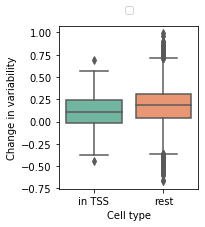

In [41]:
plt.figure(figsize=(2.5, 3))
sns.boxplot(x='isgf3', y='corr_coef', data=beta_ht_df.sort_values('isgf3'), palette='Set2')

plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.15))
# plt.ylim(-.8, 0.6)
# plt.savefig(fig_path + 'isgf3_vs_rest.pdf', bbox_inches='tight')

